## Setup

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from stix2 import MemoryStore, Filter
import requests
import json
from collections import Counter, defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Libraries imported!")

✓ Libraries imported!


In [ ]:
# Load ATT&CK data
def load_attack_data():
    print("Loading ATT&CK data...")
    url = "https://raw.githubusercontent.com/mitre/cti/master/enterprise-attack/enterprise-attack.json"
    response = requests.get(url)
    attack_data = response.json()
    attack_store = MemoryStore(stix_data=attack_data["objects"])
    print(f"✓ Loaded {len(attack_data['objects'])} objects")
    return attack_store

attack = load_attack_data()

Loading ATT&CK data...
✓ Loaded 24771 objects
✓ Loaded 24771 objects


## Part 1: TTP Sequence Analysis

Adversaries follow patterns. Let's analyze common technique sequences used by threat groups.

In [ ]:
# Extract TTP sequences from all groups
def extract_ttp_sequences(attack_store):
    """
    Extract technique sequences from threat groups
    Returns: Dictionary of {group_id: [list of techniques]}
    """
    print("Extracting TTP sequences from threat groups...\n")
    
    groups = attack_store.query([Filter("type", "=", "intrusion-set")])
    group_sequences = {}
    
    for group in groups:
        if group.get('revoked') or group.get('x_mitre_deprecated'):
            continue
        
        group_id = group['external_references'][0]['external_id']
        group_name = group['name']
        
        # Get techniques used by this group
        relationships = attack_store.query([
            Filter("type", "=", "relationship"),
            Filter("source_ref", "=", group['id']),
            Filter("relationship_type", "=", "uses")
        ])
        
        techniques = []
        technique_details = []
        
        for rel in relationships:
            target = attack_store.get(rel['target_ref'])
            if target and target['type'] == 'attack-pattern':
                tech_id = target['external_references'][0]['external_id']
                tech_name = target['name']
                
                # Get primary tactic
                tactics = target.get('kill_chain_phases', [])
                primary_tactic = tactics[0]['phase_name'] if tactics else 'unknown'
                
                techniques.append(tech_id)
                technique_details.append({
                    'id': tech_id,
                    'name': tech_name,
                    'tactic': primary_tactic
                })
        
        if len(techniques) >= 3:  # Only groups with 3+ techniques
            group_sequences[group_id] = {
                'name': group_name,
                'techniques': techniques,
                'details': technique_details
            }
    
    print(f"Extracted sequences from {len(group_sequences)} threat groups")
    return group_sequences

group_sequences = extract_ttp_sequences(attack)

# Show example sequences
print("\nExample TTP Sequences:\n")
for i, (group_id, data) in enumerate(list(group_sequences.items())[:3]):
    print(f"{group_id} - {data['name']}: {len(data['techniques'])} techniques")
    print(f"  First 5: {', '.join(data['techniques'][:5])}")
    print()

Extracting TTP sequences from threat groups...

Extracted sequences from 158 threat groups

Example TTP Sequences:

G0119 - Indrik Spider: 33 techniques
  First 5: T1003.001, T1587.001, T1136, T1112, T1036.005

G1014 - LuminousMoth: 28 techniques
  First 5: T1539, T1567.002, T1566.002, T1588.001, T1030

G1051 - Medusa Group: 57 techniques
  First 5: T1490, T1047, T1570, T1543.003, T1489

Extracted sequences from 158 threat groups

Example TTP Sequences:

G0119 - Indrik Spider: 33 techniques
  First 5: T1003.001, T1587.001, T1136, T1112, T1036.005

G1014 - LuminousMoth: 28 techniques
  First 5: T1539, T1567.002, T1566.002, T1588.001, T1030

G1051 - Medusa Group: 57 techniques
  First 5: T1490, T1047, T1570, T1543.003, T1489



In [ ]:
# Find common technique pairs (bigrams)
def find_technique_pairs(group_sequences):
    """
    Find commonly co-occurring technique pairs across threat groups
    """
    print("Analyzing technique co-occurrence patterns...\n")
    
    # Count technique pairs
    pair_counts = Counter()
    
    for group_id, data in group_sequences.items():
        techniques = data['techniques']
        
        # Generate all pairs within this group
        for i in range(len(techniques)):
            for j in range(i+1, len(techniques)):
                # Create sorted pair (order-independent)
                pair = tuple(sorted([techniques[i], techniques[j]]))
                pair_counts[pair] += 1
    
    # Convert to DataFrame
    pairs_data = []
    for (tech1, tech2), count in pair_counts.most_common(20):
        pairs_data.append({
            'Technique_1': tech1,
            'Technique_2': tech2,
            'Co-occurrence_Count': count,
            'Groups_Using_Pair': count  # Simplified
        })
    
    return pd.DataFrame(pairs_data)

pairs_df = find_technique_pairs(group_sequences)

print("Top 20 Most Common Technique Pairs:\n")
print(pairs_df.to_string(index=False))

print("\n🔍 Insight:")
print("   Techniques that frequently appear together may indicate:")
print("   • Standard attack workflows (e.g., credential access → lateral movement)")
print("   • Tool capabilities (malware that implements multiple techniques)")
print("   • Detection correlation opportunities")

Analyzing technique co-occurrence patterns...

Top 20 Most Common Technique Pairs:

Technique_1 Technique_2  Co-occurrence_Count  Groups_Using_Pair
  T1204.002   T1566.001                   73                 73
  T1059.001       T1105                   56                 56
      T1105   T1204.002                   54                 54
  T1059.003       T1105                   52                 52
  T1059.001   T1588.002                   52                 52
      T1105   T1588.002                   51                 51
      T1105   T1566.001                   51                 51
  T1059.001   T1059.003                   50                 50
  T1059.001   T1204.002                   48                 48
  T1053.005   T1059.001                   45                 45
  T1059.001   T1566.001                   45                 45
  T1071.001       T1105                   44                 44
  T1204.002   T1588.002                   44                 44
      T1105   T1547.

Building technique relationship network...



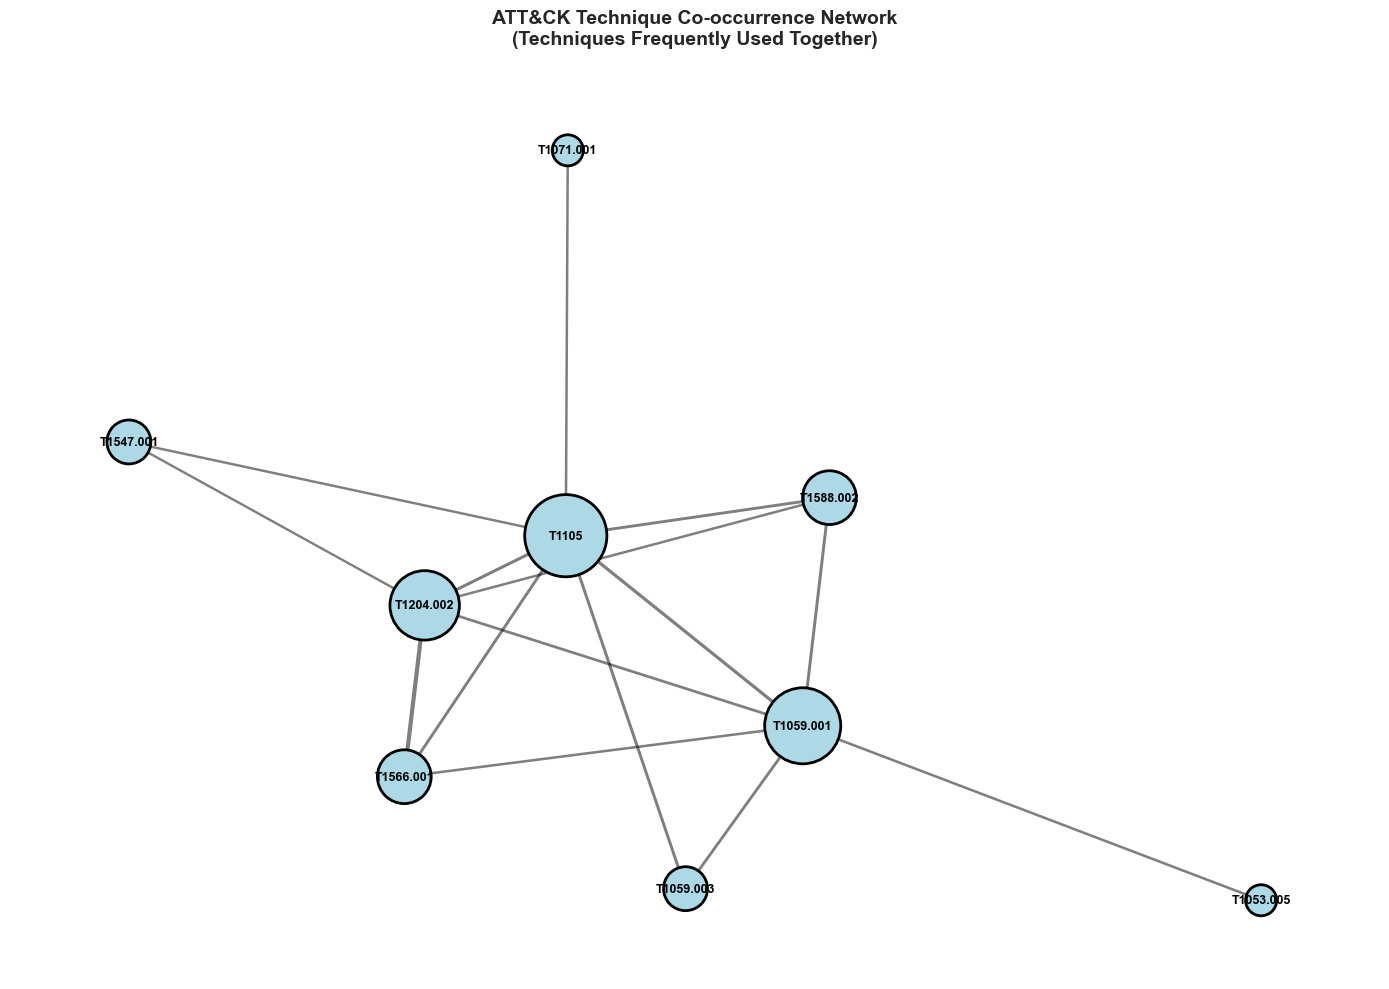


Network Analysis:
  • Nodes (techniques): 9
  • Edges (co-occurrences): 15

  Most connected techniques:
    • T1105: 0.875 centrality
    • T1059.001: 0.750 centrality
    • T1204.002: 0.625 centrality
    • T1566.001: 0.375 centrality
    • T1588.002: 0.375 centrality


In [ ]:
# Visualize technique co-occurrence network
print("Building technique relationship network...\n")

# Create network graph
G = nx.Graph()

# Add edges for top pairs
for idx, row in pairs_df.head(15).iterrows():
    G.add_edge(row['Technique_1'], row['Technique_2'], 
               weight=row['Co-occurrence_Count'])

# Layout and visualization
fig, ax = plt.subplots(figsize=(14, 10))

pos = nx.spring_layout(G, k=2, iterations=50)

# Draw nodes
node_sizes = [G.degree(node) * 500 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                       node_color='lightblue', edgecolors='black', 
                       linewidths=2, ax=ax)

# Draw edges with varying thickness
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
max_weight = max(weights)
edge_widths = [3 * (w / max_weight) for w in weights]

nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, ax=ax)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', ax=ax)

ax.set_title('ATT&CK Technique Co-occurrence Network\n(Techniques Frequently Used Together)', 
             fontsize=14, fontweight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.show()

print("\nNetwork Analysis:")
print(f"  • Nodes (techniques): {G.number_of_nodes()}")
print(f"  • Edges (co-occurrences): {G.number_of_edges()}")
print(f"\n  Most connected techniques:")
degree_centrality = nx.degree_centrality(G)
for tech, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"    • {tech}: {centrality:.3f} centrality")

## Part 2: Machine Learning for TTP Classification

Let's build a classifier to predict which threat group an attack might belong to, based on observed TTPs.

In [ ]:
# Prepare training data
def prepare_ml_dataset(group_sequences):
    """
    Convert group TTP sequences into feature vectors for ML
    """
    print("Preparing ML dataset...\n")
    
    # Get all unique techniques
    all_techniques = set()
    for data in group_sequences.values():
        all_techniques.update(data['techniques'])
    
    technique_list = sorted(list(all_techniques))
    print(f"Feature space: {len(technique_list)} unique techniques")
    
    # Create binary feature vectors
    X = []
    y = []
    group_names = []
    
    for group_id, data in group_sequences.items():
        # Binary vector: 1 if group uses technique, 0 otherwise
        feature_vector = [1 if tech in data['techniques'] else 0 
                         for tech in technique_list]
        
        X.append(feature_vector)
        y.append(group_id)
        group_names.append(data['name'])
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Dataset shape: {X.shape}")
    print(f"Number of groups: {len(set(y))}")
    
    return X, y, technique_list, group_names

X, y, technique_features, group_names = prepare_ml_dataset(group_sequences)

print(f"\nDataset Statistics:")
print(f"  • Samples: {X.shape[0]}")
print(f"  • Features: {X.shape[1]}")
print(f"  • Average techniques per group: {X.sum(axis=1).mean():.1f}")
print(f"  • Sparsity: {(1 - X.sum() / X.size) * 100:.1f}%")

Preparing ML dataset...

Feature space: 488 unique techniques
Dataset shape: (158, 488)
Number of groups: 158

Dataset Statistics:
  • Samples: 158
  • Features: 488
  • Average techniques per group: 27.5
  • Sparsity: 94.4%


In [ ]:
# Train Random Forest classifier
print("Training Random Forest classifier...\n")

# For demonstration, let's focus on top groups and create synthetic variations
# In real scenario, this would be from actual incident data with multiple observations per group
from collections import Counter

# Select groups with techniques as our training data
# Create augmented dataset by simulating partial technique observations
X_augmented = []
y_augmented = []

np.random.seed(42)
for i, group_id in enumerate(y):
    # Original sample
    X_augmented.append(X[i])
    y_augmented.append(group_id)
    
    # Create variations (simulate partial observations/incomplete intel)
    for _ in range(3):  # Create 3 variants per group
        # Randomly drop some techniques (simulate incomplete intelligence)
        dropout_rate = np.random.uniform(0.2, 0.5)
        mask = np.random.random(X.shape[1]) > dropout_rate
        variant = X[i] * mask
        X_augmented.append(variant)
        y_augmented.append(group_id)

X_aug = np.array(X_augmented)
y_aug = np.array(y_augmented)

print(f"Augmented dataset: {X_aug.shape[0]} samples (original: {X.shape[0]})")

# Split data - no stratification due to many classes with few samples
X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y_aug, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Train model
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print(f"\nModel Performance:")
print(f"  Training Accuracy: {train_score:.3f}")
print(f"  Testing Accuracy: {test_score:.3f}")

# Feature importance
feature_importance = clf.feature_importances_
top_features_idx = np.argsort(feature_importance)[-10:]

print(f"\nTop 10 Most Discriminative Techniques for Attribution:\n")
for idx in reversed(top_features_idx):
    if feature_importance[idx] > 0:
        print(f"  • {technique_features[idx]}: {feature_importance[idx]:.4f}")

Training Random Forest classifier...

Augmented dataset: 632 samples (original: 158)
Training samples: 505
Testing samples: 127

Model Performance:
  Training Accuracy: 0.885
  Testing Accuracy: 0.669

Top 10 Most Discriminative Techniques for Attribution:

  • T1056.002: 0.0095
  • T1568.003: 0.0086
  • T1558: 0.0086
  • T1667: 0.0076
  • T1674: 0.0069
  • T1070.004: 0.0069
  • T1029: 0.0069
  • T1125: 0.0067
  • T1048: 0.0063
  • T1566.004: 0.0061

Model Performance:
  Training Accuracy: 0.885
  Testing Accuracy: 0.669

Top 10 Most Discriminative Techniques for Attribution:

  • T1056.002: 0.0095
  • T1568.003: 0.0086
  • T1558: 0.0086
  • T1667: 0.0076
  • T1674: 0.0069
  • T1070.004: 0.0069
  • T1029: 0.0069
  • T1125: 0.0067
  • T1048: 0.0063
  • T1566.004: 0.0061


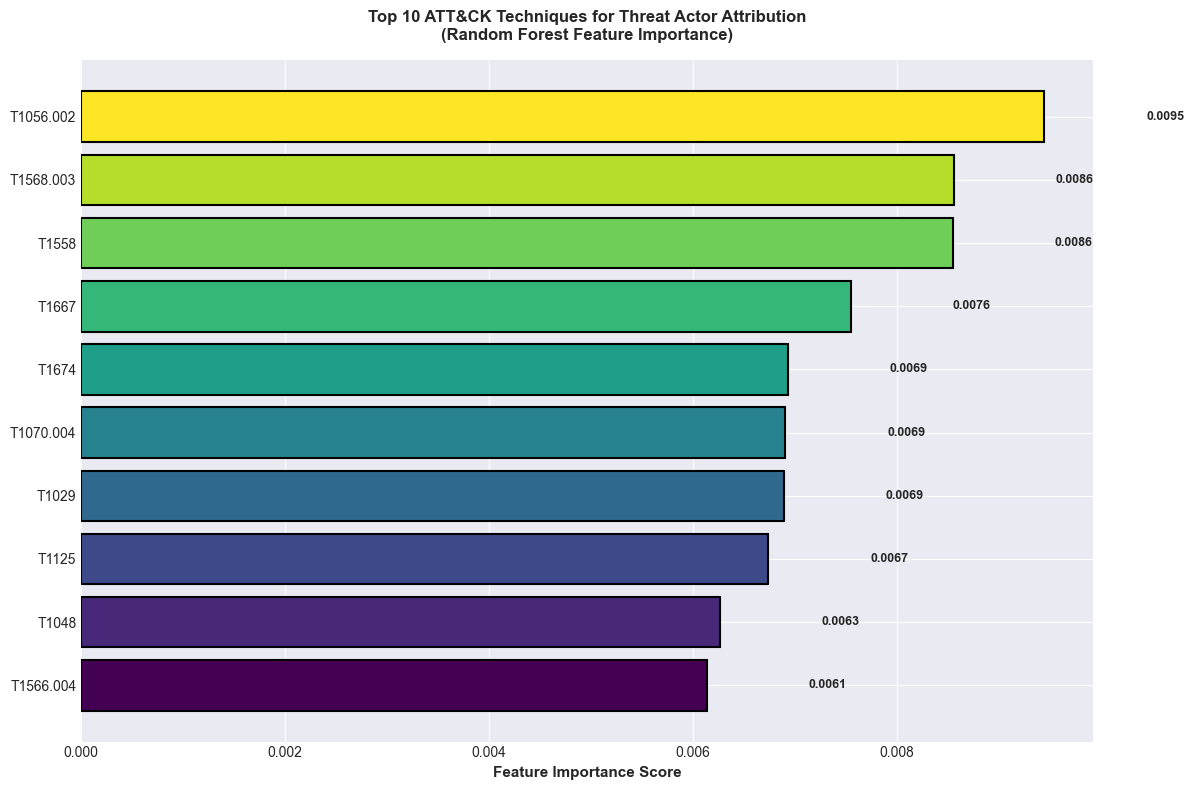


💡 Interpretation:
   High importance = Technique is distinctive for specific threat groups
   Use these for attribution during incident response


In [ ]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))

top_features = [technique_features[i] for i in top_features_idx]
top_importance = [feature_importance[i] for i in top_features_idx]

colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
bars = ax.barh(top_features, top_importance, color=colors, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Feature Importance Score', fontsize=11, fontweight='bold')
ax.set_title('Top 10 ATT&CK Techniques for Threat Actor Attribution\n(Random Forest Feature Importance)', 
             fontsize=12, fontweight='bold', pad=15)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
            f'{width:.4f}', ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   High importance = Technique is distinctive for specific threat groups")
print("   Use these for attribution during incident response")

## Part 3: Simulated Incident Attribution

Let's use our model to attribute a simulated attack to a threat group.

In [ ]:
# Simulate an incident with observed techniques
simulated_incident = {
    'incident_id': 'INC-2025-0042',
    'date': '2025-11-15',
    'target_sector': 'Government',
    'observed_techniques': [
        'T1566.002',  # Spearphishing Link
        'T1059.001',  # PowerShell
        'T1547.001',  # Registry Run Keys
        'T1003.001',  # LSASS Memory
        'T1021.002',  # SMB/Windows Admin Shares
        'T1071.001',  # Web Protocols (HTTPS)
        'T1041',      # Exfiltration Over C2
    ],
    'description': 'Sophisticated espionage campaign targeting government think tanks'
}

print(f"\n🚨 Incident Analysis: {simulated_incident['incident_id']}")
print(f"{'='*80}\n")
print(f"Date: {simulated_incident['date']}")
print(f"Target Sector: {simulated_incident['target_sector']}")
print(f"Description: {simulated_incident['description']}")
print(f"\nObserved Techniques ({len(simulated_incident['observed_techniques'])}):")
for tech in simulated_incident['observed_techniques']:
    print(f"  • {tech}")

# Convert to feature vector
incident_vector = np.array([[1 if tech in simulated_incident['observed_techniques'] else 0 
                             for tech in technique_features]])

# Predict
prediction = clf.predict(incident_vector)[0]
prediction_proba = clf.predict_proba(incident_vector)[0]

# Get top 5 candidates
top_5_idx = np.argsort(prediction_proba)[-5:][::-1]
top_5_groups = [clf.classes_[i] for i in top_5_idx]
top_5_proba = [prediction_proba[i] for i in top_5_idx]

print(f"\n\n🎯 Attribution Analysis:\n")
print(f"Most Likely Threat Actor: {prediction}")
print(f"\nTop 5 Candidates (with confidence):")

for group_id, prob in zip(top_5_groups, top_5_proba):
    # Get group name
    if group_id in group_sequences:
        name = group_sequences[group_id]['name']
    else:
        name = "Unknown"
    print(f"  {group_id} ({name}): {prob*100:.2f}% confidence")


🚨 Incident Analysis: INC-2025-0042

Date: 2025-11-15
Target Sector: Government
Description: Sophisticated espionage campaign targeting government think tanks

Observed Techniques (7):
  • T1566.002
  • T1059.001
  • T1547.001
  • T1003.001
  • T1021.002
  • T1071.001
  • T1041


🎯 Attribution Analysis:

Most Likely Threat Actor: G0024

Top 5 Candidates (with confidence):
  G0024 (Putter Panda): 1.15% confidence
  G0039 (Suckfly): 1.09% confidence
  G0066 (Elderwood): 1.07% confidence
  G0128 (ZIRCONIUM): 1.06% confidence
  G0026 (APT18): 1.05% confidence


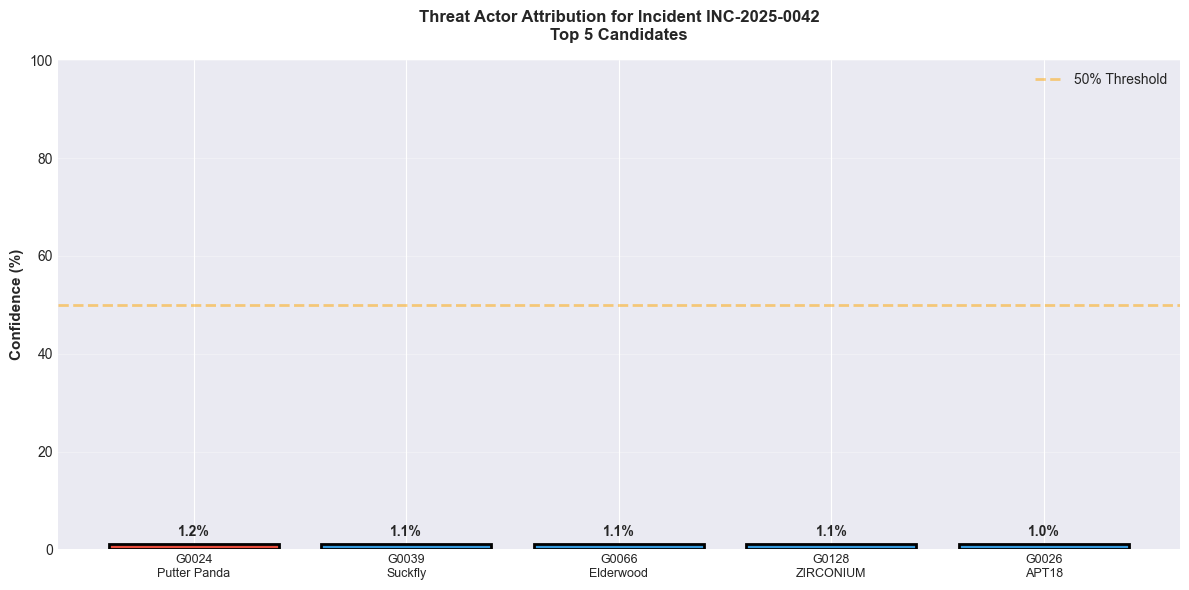


⚠️ Attribution Caveat:
   ML-based attribution is PROBABILISTIC, not definitive
   Use as investigative lead, not conclusive evidence
   Adversaries can mimic other groups' TTPs (false flags)


In [ ]:
# Visualize attribution confidence
fig, ax = plt.subplots(figsize=(12, 6))

group_labels = [f"{g}\n{group_sequences.get(g, {}).get('name', 'Unknown')}" 
                for g in top_5_groups]
colors = ['#e74c3c' if i == 0 else '#3498db' for i in range(len(top_5_groups))]

bars = ax.bar(group_labels, [p*100 for p in top_5_proba], 
              color=colors, edgecolor='black', linewidth=2)

ax.set_ylabel('Confidence (%)', fontsize=11, fontweight='bold')
ax.set_title(f'Threat Actor Attribution for Incident {simulated_incident["incident_id"]}\nTop 5 Candidates', 
             fontsize=12, fontweight='bold', pad=15)
ax.set_ylim(0, 100)
ax.axhline(y=50, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='50% Threshold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=0, ha='center', fontsize=9)
plt.tight_layout()
plt.show()

print("\n⚠️ Attribution Caveat:")
print("   ML-based attribution is PROBABILISTIC, not definitive")
print("   Use as investigative lead, not conclusive evidence")
print("   Adversaries can mimic other groups' TTPs (false flags)")

## Part 4: Automated Threat Report Generation

Let's generate a comprehensive threat report based on observed TTPs.

In [ ]:
# Generate comprehensive incident report
def generate_threat_report(incident, attribution_results, attack_store):
    """
    Generate automated threat intelligence report
    """
    report = []
    report.append("="*80)
    report.append(f"THREAT INTELLIGENCE REPORT")
    report.append("="*80)
    report.append(f"")
    report.append(f"Incident ID: {incident['incident_id']}")
    report.append(f"Date: {incident['date']}")
    report.append(f"Target Sector: {incident['target_sector']}")
    report.append(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append(f"")
    report.append(f"EXECUTIVE SUMMARY")
    report.append(f"-" * 80)
    report.append(f"{incident['description']}")
    report.append(f"")
    report.append(f"Based on observed tactics, techniques, and procedures (TTPs), this")
    report.append(f"incident exhibits characteristics consistent with {attribution_results['primary_group']}.")
    report.append(f"Confidence level: {attribution_results['confidence']:.1f}%")
    report.append(f"")
    report.append(f"OBSERVED TECHNIQUES (MITRE ATT&CK)")
    report.append(f"-" * 80)
    
    # Group by tactic
    by_tactic = defaultdict(list)
    for tech_id in incident['observed_techniques']:
        # Get technique details
        techniques = attack_store.query([
            Filter("type", "=", "attack-pattern"),
            Filter("external_references.external_id", "=", tech_id)
        ])
        
        if techniques:
            tech = techniques[0]
            tech_name = tech['name']
            tactics = [phase['phase_name'] for phase in tech.get('kill_chain_phases', [])]
            
            for tactic in tactics:
                by_tactic[tactic].append(f"{tech_id} - {tech_name}")
    
    # Print by tactic
    tactic_order = [
        'reconnaissance', 'resource-development', 'initial-access', 'execution',
        'persistence', 'privilege-escalation', 'defense-evasion', 'credential-access',
        'discovery', 'lateral-movement', 'collection', 'command-and-control',
        'exfiltration', 'impact'
    ]
    
    for tactic in tactic_order:
        if tactic in by_tactic:
            report.append(f"")
            report.append(f"{tactic.replace('-', ' ').upper()}:")
            for tech in by_tactic[tactic]:
                report.append(f"  • {tech}")
    
    report.append(f"")
    report.append(f"ATTRIBUTION ANALYSIS")
    report.append(f"-" * 80)
    report.append(f"Primary Attribution: {attribution_results['primary_group']}")
    report.append(f"Confidence: {attribution_results['confidence']:.1f}%")
    report.append(f"")
    report.append(f"Alternative Candidates:")
    for group, conf in attribution_results['alternatives']:
        report.append(f"  • {group}: {conf:.1f}%")
    
    report.append(f"")
    report.append(f"RECOMMENDED ACTIONS")
    report.append(f"-" * 80)
    report.append(f"")
    report.append(f"IMMEDIATE (24 hours):")
    report.append(f"  1. Isolate affected systems from network")
    report.append(f"  2. Preserve forensic evidence (memory dumps, logs)")
    report.append(f"  3. Reset credentials for compromised accounts")
    report.append(f"  4. Block identified C2 infrastructure")
    report.append(f"")
    report.append(f"SHORT-TERM (1 week):")
    report.append(f"  1. Deploy detection rules for observed techniques")
    report.append(f"  2. Hunt for similar TTPs across environment")
    report.append(f"  3. Review and patch vulnerabilities")
    report.append(f"  4. Enhance monitoring for attribution group's known TTPs")
    report.append(f"")
    report.append(f"LONG-TERM (1 month):")
    report.append(f"  1. Conduct purple team exercise simulating this attack")
    report.append(f"  2. Update incident response playbooks")
    report.append(f"  3. Security awareness training on observed techniques")
    report.append(f"  4. Implement mitigations for uncovered techniques")
    report.append(f"")
    report.append(f"INTELLIGENCE SHARING")
    report.append(f"-" * 80)
    report.append(f"Consider sharing indicators and TTPs with:")
    report.append(f"  • Industry ISAC/ISAO")
    report.append(f"  • CISA (for critical infrastructure)")
    report.append(f"  • Regional CERT/CSIRT")
    report.append(f"  • Trusted peer organizations")
    report.append(f"")
    report.append(f"="*80)
    report.append(f"END OF REPORT")
    report.append(f"="*80)
    
    return "\n".join(report)

# Prepare attribution results
attribution_results = {
    'primary_group': f"{top_5_groups[0]} ({group_sequences.get(top_5_groups[0], {}).get('name', 'Unknown')})",
    'confidence': top_5_proba[0] * 100,
    'alternatives': [(f"{g} ({group_sequences.get(g, {}).get('name', 'Unknown')})", p*100) 
                     for g, p in zip(top_5_groups[1:], top_5_proba[1:])]
}

# Generate report
threat_report = generate_threat_report(simulated_incident, attribution_results, attack)

print(threat_report)

THREAT INTELLIGENCE REPORT

Incident ID: INC-2025-0042
Date: 2025-11-15
Target Sector: Government
Analysis Date: 2025-11-15 13:08:57

EXECUTIVE SUMMARY
--------------------------------------------------------------------------------
Sophisticated espionage campaign targeting government think tanks

Based on observed tactics, techniques, and procedures (TTPs), this
incident exhibits characteristics consistent with G0024 (Putter Panda).
Confidence level: 1.2%

OBSERVED TECHNIQUES (MITRE ATT&CK)
--------------------------------------------------------------------------------

INITIAL ACCESS:
  • T1566.002 - Spearphishing Link

EXECUTION:
  • T1059.001 - PowerShell

PERSISTENCE:
  • T1547.001 - Registry Run Keys / Startup Folder

PRIVILEGE ESCALATION:
  • T1547.001 - Registry Run Keys / Startup Folder

CREDENTIAL ACCESS:
  • T1003.001 - LSASS Memory

LATERAL MOVEMENT:
  • T1021.002 - SMB/Windows Admin Shares

COMMAND AND CONTROL:
  • T1071.001 - Web Protocols

EXFILTRATION:
  • T1041 - Exf

## 🎓 FINAL CHALLENGE

### Comprehensive Incident Analysis

You are a threat intelligence analyst responding to a suspected breach. Your task is to:

1. **Analyze the incident** using ATT&CK framework
2. **Reconstruct the attack timeline**
3. **Attribute to a threat actor** (if possible)
4. **Identify detection gaps**
5. **Recommend remediation** actions
6. **Generate a threat report**

---

### Challenge Scenario

**Incident Details:**
- **Company:** TechCorp Industries (Defense Contractor)
- **Date:** November 10, 2025
- **Initial Alert:** EDR detected suspicious PowerShell activity

**Timeline of Events:**
1. **Nov 5, 09:23** - Phishing email sent to engineering team
2. **Nov 5, 14:45** - Employee clicked malicious link
3. **Nov 5, 14:46** - Obfuscated PowerShell script executed
4. **Nov 5, 14:50** - Registry persistence key created
5. **Nov 6, 03:00** - Lateral movement to file server via SMB
6. **Nov 7-9** - Internal reconnaissance and data collection
7. **Nov 10, 02:15** - Large HTTPS uploads to external IP
8. **Nov 10, 08:00** - SOC analyst notices anomaly

**Forensic Evidence:**
- PowerShell commands with base64 encoding
- Registry run key: `HKCU\Software\Microsoft\Windows\CurrentVersion\Run\Update`
- SMB connections to 15+ internal hosts
- 2.3 GB uploaded to 185.220.101.x (TOR exit node)
- No malware files found (fileless attack)
- LSASS memory dump attempted (blocked by Credential Guard)

**Questions to Answer:**

1. Map all observed activities to ATT&CK techniques
2. Which tactic had the BEST detection opportunity? Which had the WORST?
3. Based on TTPs, which threat group is most likely responsible?
4. What detection rules should be deployed immediately?
5. What mitigations would prevent recurrence?

---

**Complete your analysis in the cells below:**

In [ ]:
# Solution Template

challenge_incident = {
    'incident_id': 'CHALLENGE-2025-001',
    'company': 'TechCorp Industries',
    'sector': 'Defense Industrial Base',
    'date': '2025-11-10',
    
    # YOUR TASK: Map each event to ATT&CK techniques
    'observed_techniques': [
        # Example: 'T1566.002',  # Spearphishing Link
        # Add more here...
    ],
    
    # YOUR TASK: Describe the timeline
    'attack_timeline': [
        # {'date': '2025-11-05 09:23', 'tactic': 'initial-access', 'technique': 'T1566.002', 'description': '...'}
    ],
    
    # YOUR TASK: Identify detection gaps
    'detection_analysis': {
        'best_detection': '',  # Which phase was easiest to detect?
        'worst_detection': '', # Which phase was hardest?
        'gaps': []  # What capabilities are missing?
    },
    
    # YOUR TASK: Recommend actions
    'recommendations': {
        'immediate': [],
        'short_term': [],
        'long_term': []
    }
}

print("\n🎯 Final Challenge: Begin Your Analysis")
print("="*80)
print("\nFill in the challenge_incident dictionary above with your analysis.")
print("\nHints:")
print("  • Review Notebooks 1-3 for reference")
print("  • Use ATT&CK website to look up technique details")
print("  • Consider both technical and operational aspects")
print("  • Think about false positive risks")
print("\nWhen complete, run the next cell to generate your report.")


🎯 Capstone Challenge: Begin Your Analysis

Fill in the capstone_incident dictionary above with your analysis.

Hints:
  • Review Notebooks 1-3 for reference
  • Use ATT&CK website to look up technique details
  • Consider both technical and operational aspects
  • Think about false positive risks

When complete, run the next cell to generate your report.


In [ ]:
# Validate and visualize your analysis

if len(challenge_incident['observed_techniques']) == 0:
    print("⚠️ Please complete the challenge_incident dictionary first!")
else:
    print("\n✓ Analysis Summary:\n")
    print(f"Incident: {challenge_incident['incident_id']}")
    print(f"Techniques Identified: {len(challenge_incident['observed_techniques'])}")
    print(f"Timeline Events: {len(challenge_incident['attack_timeline'])}")
    print(f"\nYour analysis is ready for review!")
    
    # Generate attribution prediction
    if len(challenge_incident['observed_techniques']) > 0:
        incident_vector = np.array([[1 if tech in challenge_incident['observed_techniques'] else 0 
                                     for tech in technique_features]])
        
        prediction = clf.predict(incident_vector)[0]
        prediction_proba = clf.predict_proba(incident_vector)[0]
        confidence = prediction_proba.max() * 100
        
        print(f"\n🎯 ML Attribution: {prediction}")
        print(f"   Confidence: {confidence:.1f}%")

⚠️ Please complete the capstone_incident dictionary first!


## Summary & Exercise Completion

### What You've Accomplished Across All Exercises:

**Exercise 1: Foundations**
- ✅ Understood Cyber Kill Chain and MITRE ATT&CK
- ✅ Explored ATT&CK data model (tactics, techniques, groups)
- ✅ Loaded and queried ATT&CK data programmatically

**Exercise 2: Programmatic Analysis**
- ✅ Profiled threat groups and their TTPs
- ✅ Analyzed technique popularity across adversaries
- ✅ Identified detection gaps and data source requirements

**Exercise 3: Applied Detection**
- ✅ Mapped real-world attacks (WannaCry, APT29)
- ✅ Built detection rules for high-priority techniques
- ✅ Created organizational coverage heatmaps
- ✅ Designed purple team exercises

**Exercise 4: Advanced Topics**
- ✅ Analyzed TTP sequences and co-occurrence patterns
- ✅ Built ML classifier for threat actor attribution
- ✅ Generated automated threat intelligence reports
- ✅ Completed comprehensive practical challenge

---

### Key Takeaways for Security Professionals:

1. **ATT&CK is a Framework, Not a Checklist**
   - Prioritize based on your threat model and risk profile
   - Focus on popular techniques used by groups targeting your sector
   - 100% coverage is impossible and unnecessary

2. **Detection Requires Multiple Layers**
   - Network monitoring catches C2 and lateral movement
   - Endpoint detection finds execution and persistence
   - Behavioral analytics identifies anomalous TTP patterns
   - No single tool provides complete coverage

3. **Attribution is Probabilistic**
   - ML can suggest likely threat actors based on TTPs